# EE4414 Lab Part1_Image_Classification

## Acknowledgment

This lab experiment is modified based on the Pytorch official tutorial.

You can check the Pytorch official tutorial at https://pytorch.org/tutorials/



## 1. Training a classifier

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

For this part, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

We will do the following steps in order:

1) Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
   
2) Define a Convolutional Neural Network

3) Define a loss function

4) Train the network on the training data

5) Test the network on the test data

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np


### 1.1 Loading and normalizing CIFAR10


Using ``torchvision``, it is easy to load CIFAR10.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified



### 1.2 Visualizing the training images


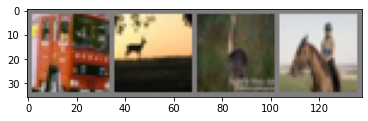

truck  deer  bird horse


In [4]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # matplotlib (plt.imshow()) expects the channels to be the last dimension, in the order (height, width, channels), thus transpose is needed
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #(channels, height, width)
    plt.show()


# get some random training images
dataiter = iter(trainloader)
# images, labels = dataiter.next() # Use this in pytorch 1.12
images, labels = next(dataiter) # Use this in pytorch 1.13

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 1.3 Getting samples from dataloader

In [5]:
dataiter = iter(trainloader)
# images, labels = dataiter.next() # Use this in pytorch 1.12
images, labels = next(dataiter) # Use this in pytorch 1.13
np.shape(images[0]) #rgb, height, width

torch.Size([3, 32, 32])

### 1.4 Defining a Convolutional Neural Network



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1) # It takes an input with 3 channels (assuming RGB images), outputs 6 channels, uses a 3x3 kernel size, and applies padding of 1.
        self.pool = nn.MaxPool2d(2, 2) # It applies 2x2 max pooling operation with a stride of 2.
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1) #It takes an input with 6 channels (output from the previous layer), outputs 16 channels, uses a 3x3 kernel size, and applies padding of 1.
        self.fc1 = nn.Linear(16 * 8 * 8, 120) # This line defines the first fully connected (dense) layer (fc1). It takes the output from the convolutional layers and flattens it into a single dimension (16 * 8 * 8), then passes it through a layer with 120 output features.
        self.fc2 = nn.Linear(120, 84) #This line defines the second fully connected layer (fc2). It takes the output from fc1 (120 features) and passes it through a layer with 84 output features.
        self.fc3 = nn.Linear(84, 10) # This line defines the third fully connected layer (fc3). It takes the output from fc2 (84 features) and passes it through a layer with 10 output features, which corresponds to the number of classes in the classification task.

    #forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net() #initialise the convolutional neural network

### 1.5 Printing the network structure

In [7]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 1.6 Using Torchsummary to visualize shape of the feature maps in each layer

In [8]:
from torchsummary import summary
summary(net, input_size=(3, 32, 32)) # Here the input size is channel x width x height

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
         MaxPool2d-2            [-1, 6, 16, 16]               0
            Conv2d-3           [-1, 16, 16, 16]             880
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Linear-5                  [-1, 120]         123,000
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 135,062
Trainable params: 135,062
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.52
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


### 1.7 Defining loss function and optimizer

The loss function here is defined as a Classification Cross-Entropy loss and SGD with momentum.



In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #setting up environment for training

### 1.8 Training the network

We loop over our data iterator, and feed the inputs to the
network and optimize the parameters.



In [10]:
t1 = time.time()
loss_list = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) #convlutional nn and forward pass 
        loss = criterion(outputs, labels) #cross entropy loss
        loss.backward() #backpropagation
        optimizer.step() #optimisation: optimizer updates the parameters of the model using the gradients and the specified optimization algorithm 

        # print statistics
        running_loss += loss.item() #accumulation of loss every 2000 mini-batches
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_list.append(running_loss/2000) #plotting purpose
            running_loss = 0.0

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

[1,  2000] loss: 2.188
[1,  4000] loss: 1.834
[1,  6000] loss: 1.623
[1,  8000] loss: 1.495
[1, 10000] loss: 1.435
[1, 12000] loss: 1.384
[2,  2000] loss: 1.282
[2,  4000] loss: 1.279
[2,  6000] loss: 1.228
[2,  8000] loss: 1.195
[2, 10000] loss: 1.166
[2, 12000] loss: 1.155
Finished Training
Training time:66.41683888435364


## Exercise 1.1 Plotting of loss function

In the previous cell, we have saved the loss function at different iterations in the loss_list.

Now, plot the loss function versus the iteration number using matplotlib.

You can find the tutorial of plotting figure using matplotlib here:
https://matplotlib.org/3.3.3/gallery/lines_bars_and_markers/simple_plot.html#sphx-glr-gallery-lines-bars-and-markers-simple-plot-py

### E1.1.1 Example of using matplotlib.pyplot

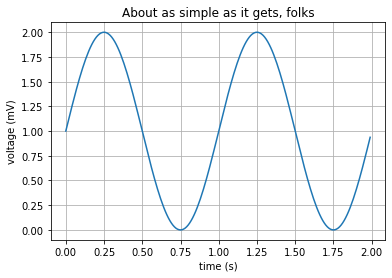

In [12]:
# An example of a simple plot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

plt.show()

### E1.1.2 Plotting the loss function vs interation number (To do)

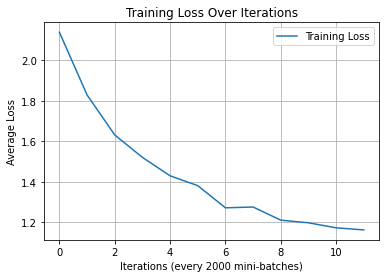

In [13]:
# Plot the training loss curve
# To do
import matplotlib.pyplot as plt

# Plot the loss function
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iterations (every 2000 mini-batches)')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()



### 1.9 Saving the trained model

In [14]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See https://pytorch.org/docs/stable/notes/serialization.html
for more details on saving PyTorch models.

### 1.10 Evaluating network performance on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnd anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.



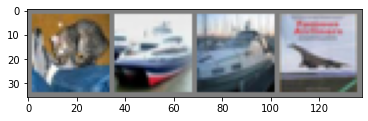

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
# images, labels = dataiter.next() # Use this in pytorch 1.12
images, labels = next(dataiter) # Use this in pytorch 1.13

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 1.11 Loading the saved model 
Note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so



In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 1.12 Predicting using the loaded model



In [17]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.

### 1.13 Getting the index of the highest energy



In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


## Exercise 1.2 Evaluating network performance 

In this section, we are going to evaluate the average accuracy for the whole test dataset and find out which classes performed well, and the classes that did not perform well.

Finish the code and calculate the accuracy for each class.


In [20]:
class_correct = list(0. for _ in range(10))
class_total = list(0. for _ in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):            
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1  # Update total count for this class

for i in range(10):
    if class_total[i] != 0:
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    else:
        print('Accuracy of %5s : %2d %%' % (classes[i], 0))  # Handle case where class_total[i] is zero


Accuracy of plane : 60 %
Accuracy of   car : 82 %
Accuracy of  bird : 22 %
Accuracy of   cat : 52 %
Accuracy of  deer : 72 %
Accuracy of   dog : 28 %
Accuracy of  frog : 71 %
Accuracy of horse : 68 %
Accuracy of  ship : 63 %
Accuracy of truck : 65 %


## Exercise 1.3 Study of different optimizers

In this exercise, you will learn to train the network using a different optimizer.

In the previous section, we used Stochastic Gradient Descent (SGD). You will use Adam optimizer in this exercise and compare the training process for these two optimizers.

### E1.3.1 Re-initializing the network

In [21]:
net = Net()

### E1.3.2 Defining the Adam optimizer (To do)

You can find the details of Pytorch Adam optimizer here: https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam

Use default parameters: lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False.

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# To do
# optimizer = complete this part
optimizer = optim.Adam(net.parameters()) 


### E1.3.3 Training the network with Adam optimizer

In [23]:
t1 = time.time()
loss_list_adam = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_list_adam.append(running_loss/2000)
            running_loss = 0.0

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

[1,  2000] loss: 1.790
[1,  4000] loss: 1.506
[1,  6000] loss: 1.406
[1,  8000] loss: 1.333
[1, 10000] loss: 1.322
[1, 12000] loss: 1.271
[2,  2000] loss: 1.164
[2,  4000] loss: 1.170
[2,  6000] loss: 1.154
[2,  8000] loss: 1.147
[2, 10000] loss: 1.128
[2, 12000] loss: 1.123
Finished Training
Training time:119.00637865066528


In the previous section, we saved the loss value of different iterations in the loss_list for the SGD optimizer.

The loss values for Adam optimizer are stored in loss_list_adam.

Now, plot the two curves in the same figure and compare them.

### E1.3.4 Example of plotting multiple curves

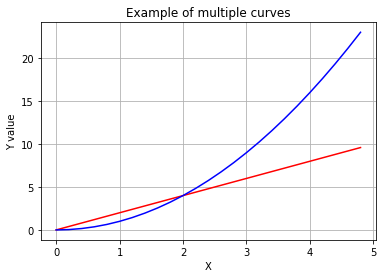

In [24]:
# Here is an example of plotting multiple curves in one figure
# evenly sampled time at 200ms intervals
fig, ax = plt.subplots()
t = np.arange(0., 5., 0.2)

# 'r' means red for the first curve, 'b' means blue for the second curve.
ax.plot(t, t*2, 'r', t, t**2, 'b')
ax.set(xlabel='X', ylabel='Y value',
       title='Example of multiple curves')
ax.grid()
plt.show()

### E1.3.5 Plotting the loss graphs for both SGD and Adam optimizers (To do)

Note: Use red color for SGD and blue color for Adam when plotting the graphs.

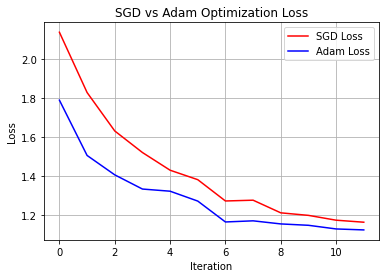

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Assuming loss_list and loss_list_adam are defined somewhere in your code
# 'r' means red for the first curve, 'b' means blue for the second curve.
ax.plot(loss_list, 'r', label='SGD Loss')
ax.plot(loss_list_adam, 'b', label='Adam Loss')

ax.set(xlabel='Iteration', ylabel='Loss',
       title='SGD vs Adam Optimization Loss')
ax.grid()
ax.legend()  # Add legend to differentiate between SGD and Adam losses
plt.show()


## Exercise 1.4 Study of different learning rates

In this exercise, you will learn to train the network using a different learning rate.
We will use SGD in this exercise.
The learning rate for the previous experiments is 0.001, we will use 0.01 in this new experiment.

### E1.4.1 Re-initializing the network.

In [28]:
net = Net()

### E1.4.2 Changing the learning rate for SGD optimizer (To do)

In [31]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# To do
# optimizer = optim.SGD(net.parameters(), lr= #to do#, momentum=0.9)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) #setting up environment for training


### E1.4.3 Training the network with larger learning rate

In [32]:
t1 = time.time()
loss_list_larger_lr = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_list_larger_lr.append(running_loss/2000)
            running_loss = 0.0

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

[1,  2000] loss: 1.721
[1,  4000] loss: 1.807
[1,  6000] loss: 1.820
[1,  8000] loss: 1.868
[1, 10000] loss: 1.822
[1, 12000] loss: 1.869
[2,  2000] loss: 1.848
[2,  4000] loss: 1.878
[2,  6000] loss: 1.889
[2,  8000] loss: 1.905
[2, 10000] loss: 1.887
[2, 12000] loss: 1.891
Finished Training
Training time:59.81019186973572


### E1.4.4 Plotting the loss curves for both learning rates (To do)

In the previous section, we have saved the loss value of different iterations in the loss_list for the 0.001 learning rate with SGD optimizer.

Now, plot the two curves in the same figure and compare them.

Note: Use red color for learning rate of 0.001 and blue color for learning rate of 0.01 when plotting the graphs.

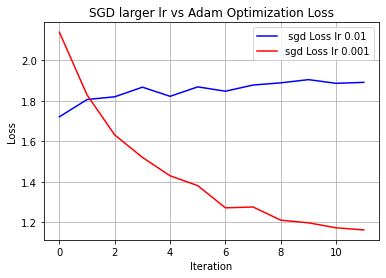

In [34]:
# To do
# Plot the training loss curve
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Assuming loss_list and loss_list_adam are defined somewhere in your code
# 'r' means red for the first curve, 'b' means blue for the second curve.
ax.plot(loss_list_larger_lr, 'b', label=' sgd Loss lr 0.01')
ax.plot(loss_list, 'r', label='sgd Loss lr 0.001')

ax.set(xlabel='Iteration', ylabel='Loss',
       title='SGD larger lr vs Adam Optimization Loss')
ax.grid()
ax.legend()  # Add legend to differentiate between SGD and Adam losses
plt.show()
